In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import misc
plt.style.use('ggplot')
%matplotlib notebook
from sklearn.cluster import KMeans

### CDRs

The dataset contains call records for 10 people, tracked over the course of 3 years. My job in this assignment is to find out where each of these people likely live and where they work at!

In [37]:
df = pd.read_csv("C:/Users/SUYASH/PycharmProjects/Datasets/CDR.csv")

In [38]:
df.head(3)

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389


In [39]:
df.dtypes

In             int64
Out            int64
Direction     object
CallDate      object
CallTime      object
DOW           object
Duration      object
TowerID       object
TowerLat     float64
TowerLon     float64
dtype: object

In [40]:
df['CallDate'] = pd.to_datetime(df['CallDate'])
df['CallTime'] = pd.to_timedelta(df['CallTime'])
#df['Duration'] = pd.to_timedelta(df['CallTime'])

In [41]:
df.head(3)

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389


Created a distinct list of `In` phone numbers (people) and stored the values in a regular python list.

In [42]:
jj = pd.unique(df.In).tolist()

In [43]:
jj

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

Created a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on unique list above, i.e., the very first number in the dataset:

In [44]:
user1 = df[df.In == jj[0]]

Plotting all the call locations:

<IPython.core.display.Javascript object>


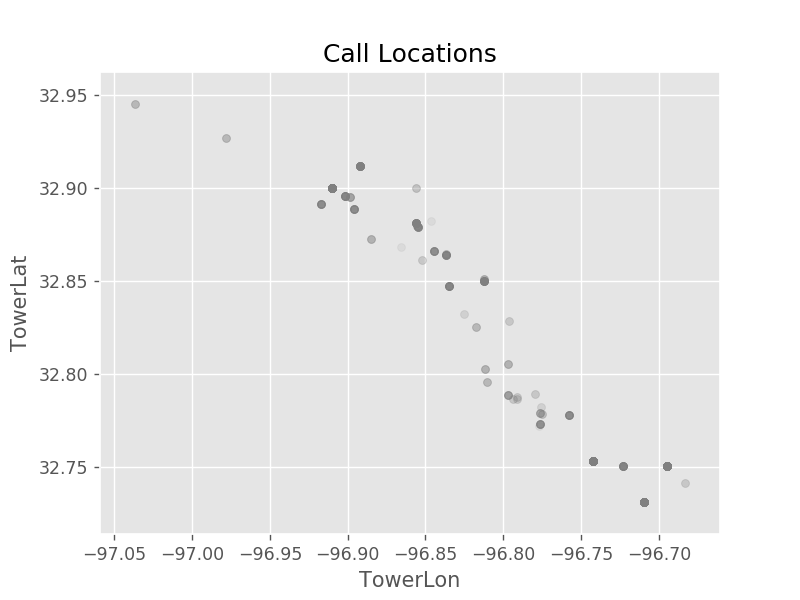

In [45]:
user1.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations')
plt.show()

This is where domain expertise comes into play. Intuition can direct us by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

Adding more filters to the `user1` slice created. Added bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):

In [47]:
user1 = df[(df.In == jj[0]) & (df.DOW == 'Sun') ]

Further filtering `user1` down for calls that came in either before 6AM OR after 10pm (22:00:00). 

In [56]:
user1 = user1[(user1.CallTime < "06:00:00") | (user1.CallTime > "22:00:00")]

In [57]:
user1.head(5)

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
157,8549533077,7780268236,Missed,2010-12-26,22:10:43.189695,Sun,0:04:58.647676,c5320bc2-eb83-4670-9194-1ec1f14bc9d1,32.772361,-96.777278
1080,8549533077,2362231379,Incoming,2011-01-09,22:47:36.239080,Sun,0:05:01.454767,6c1f0271-70e2-4ea6-bb8b-23b3b0b06117,32.772361,-96.777278
2491,8549533077,1351945852,Missed,2011-01-30,22:48:34.468662,Sun,0:02:17.547673,c5320bc2-eb83-4670-9194-1ec1f14bc9d1,32.772361,-96.777278
4330,8549533077,2288700880,Incoming,2011-02-27,05:51:48.772111,Sun,0:01:35.208890,c5320bc2-eb83-4670-9194-1ec1f14bc9d1,32.772361,-96.777278
5216,8549533077,491169353,Incoming,2011-03-13,22:21:05.384133,Sun,0:03:15.932359,6c1f0271-70e2-4ea6-bb8b-23b3b0b06117,32.772361,-96.777278


Visualizing the dataframe with a scatter plot as a sanity check. X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude.
 
At this point, we don't yet know exactly where the user is located just based off the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

<IPython.core.display.Javascript object>


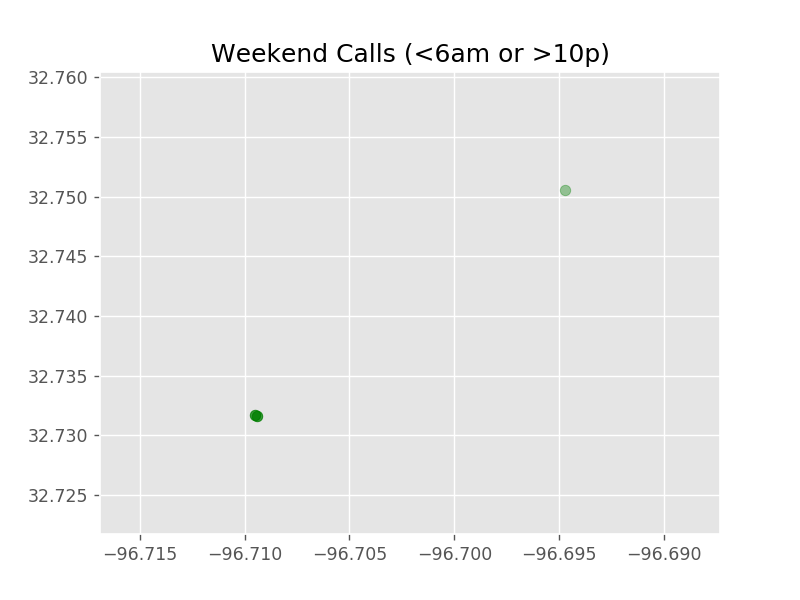

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')
plt.show()

Run K-Means with a `K=1`. There really should only be a single area of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), then increase `K=2`, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

In [51]:
def doKmeans(dd,clus):
    
    df = pd.concat([dd.TowerLat,dd.TowerLon], axis =1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x = df.TowerLat, y = df.TowerLon , marker = ".", alpha = 0.4 , s = 30)
    
    kmeans_model = KMeans(n_clusters = clus, init = 'random', n_init = 60, max_iter = 360, random_state = 43)
    labels = kmeans_model.fit_predict(df)
    centroids = kmeans_model.cluster_centers_
    ax1.scatter(x = centroids[:,0], y = centroids[:,1], marker = 'x', c = 'red', alpha = 0.9, linewidths=3, s = 120)

In [ ]:
plt.show()

Repeating the above steps for all 10 individuals in the dataset, being sure to record their approximate home locations.

<IPython.core.display.Javascript object>


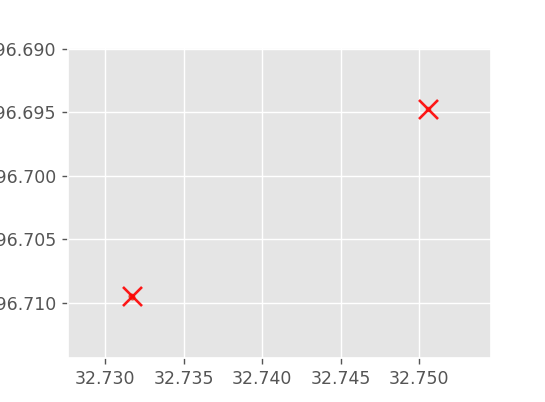

<IPython.core.display.Javascript object>


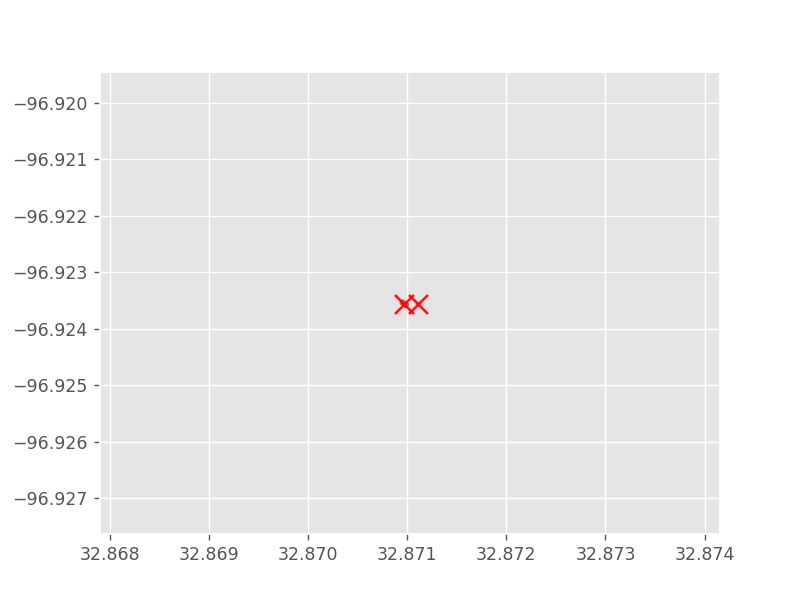

<IPython.core.display.Javascript object>


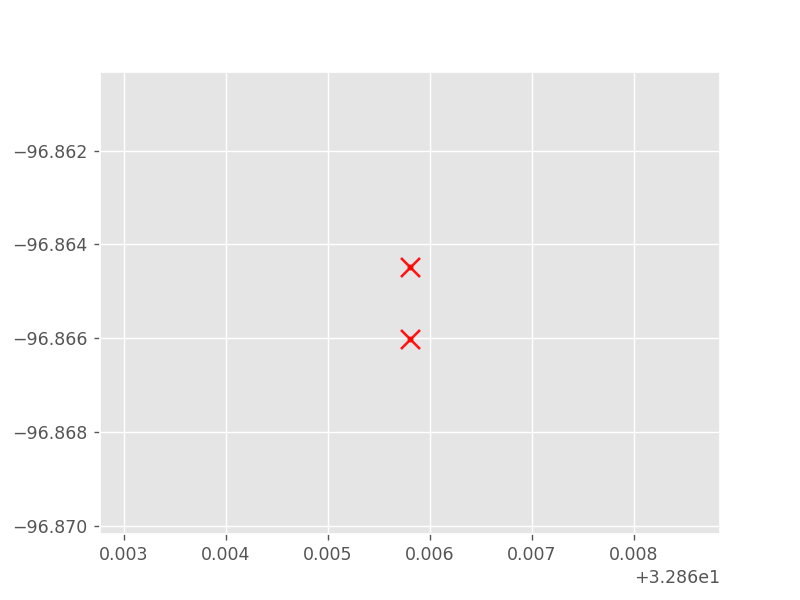

<IPython.core.display.Javascript object>


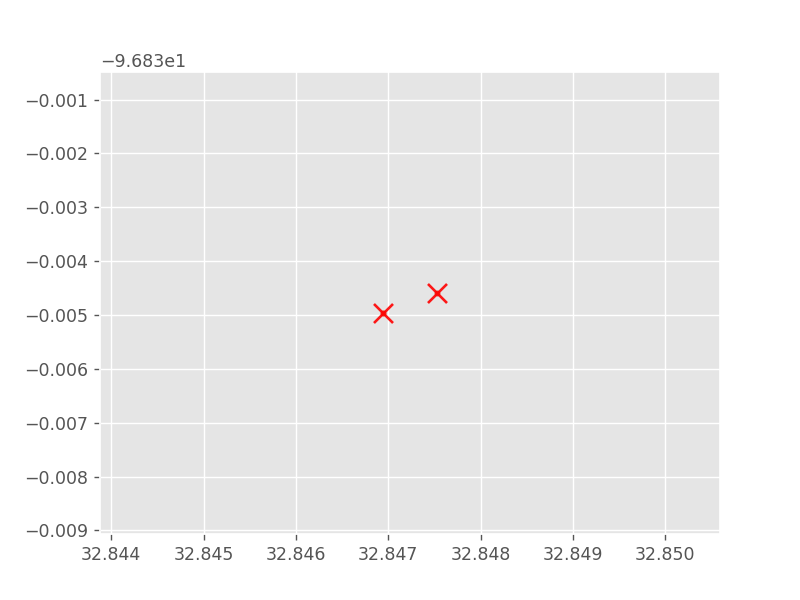

<IPython.core.display.Javascript object>


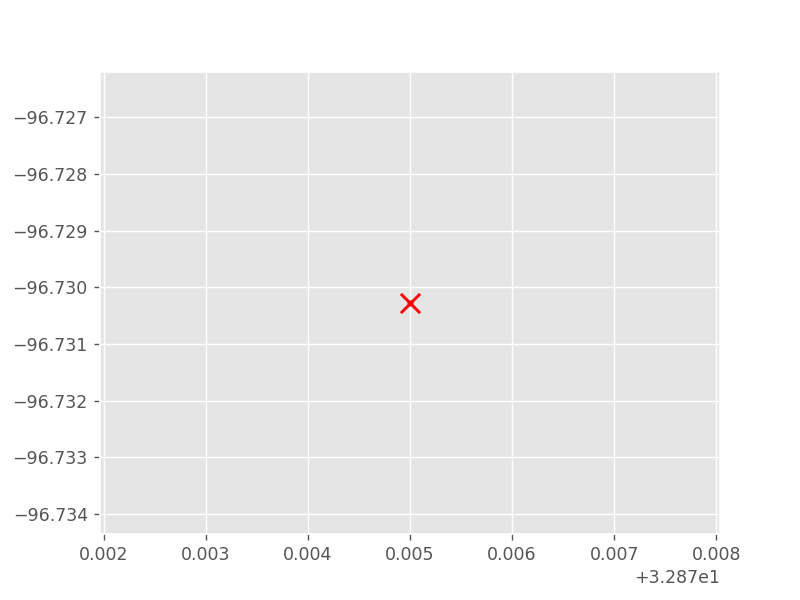

<IPython.core.display.Javascript object>


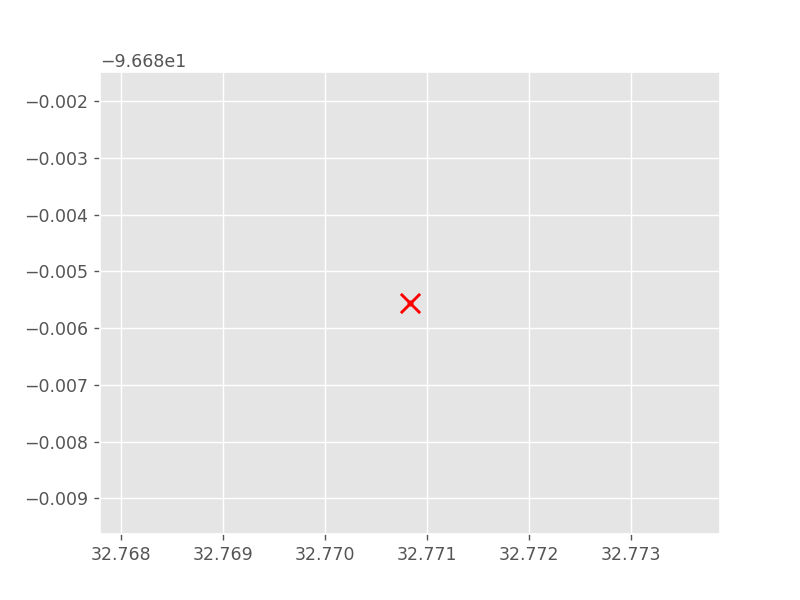

<IPython.core.display.Javascript object>


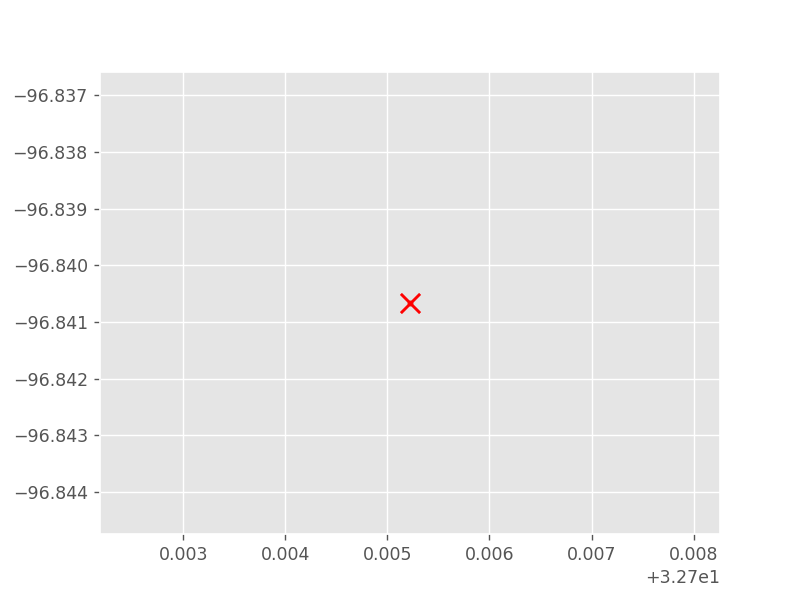

<IPython.core.display.Javascript object>


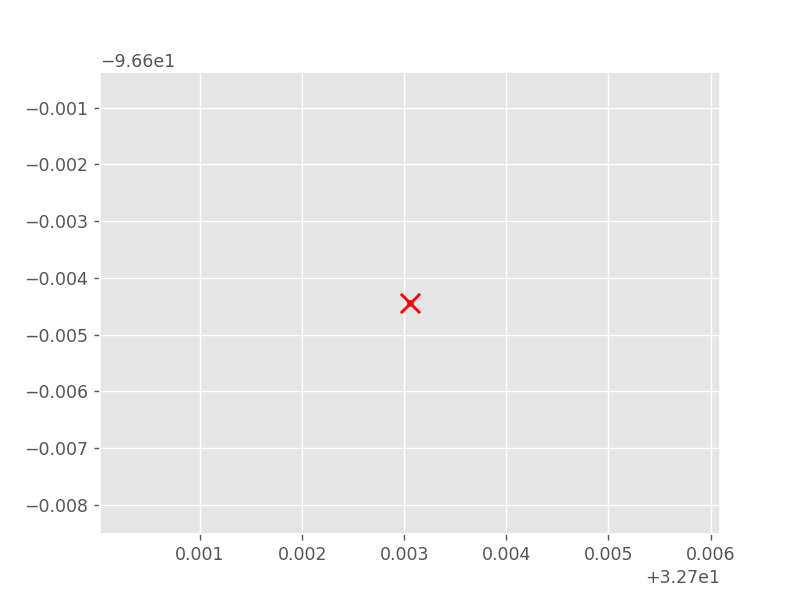

<IPython.core.display.Javascript object>


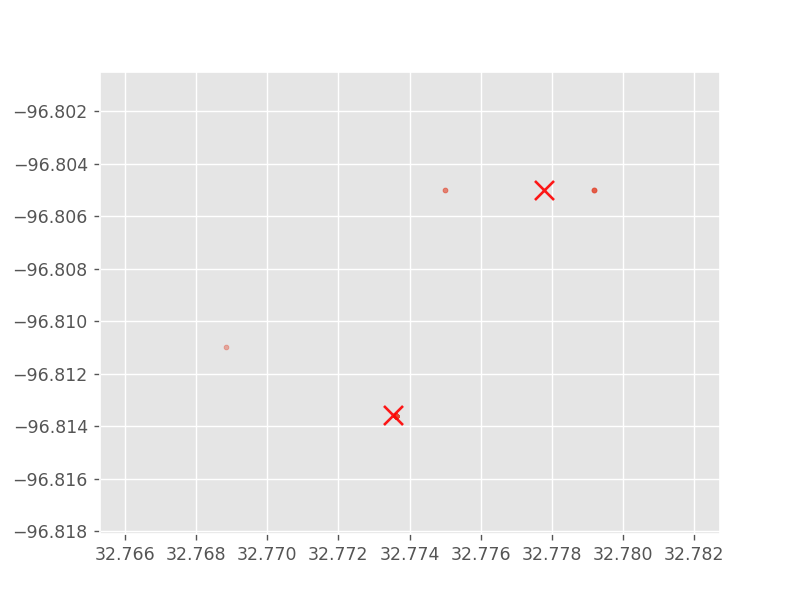

<IPython.core.display.Javascript object>


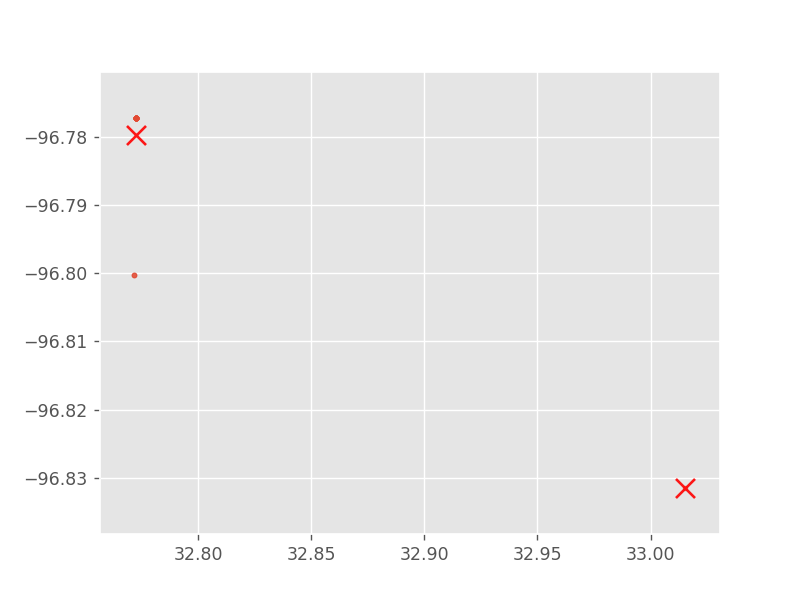

In [58]:
for i in range(len(jj)):
    user1 = df[(df.In == jj[i]) & (df.DOW == 'Sun') ]
    user1 = user1[(user1.CallTime < "06:00:00") | (user1.CallTime > "22:00:00")]
    doKmeans(user1,2)

In [54]:
jj

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

In [ ]:
04638472273